In [1]:
import ROOT as r
import numpy as np
import math

Welcome to JupyROOT 6.22/00


In [2]:
f = r.TFile("samples/ZZTo4mu_skim.root")
f.ls()
t = f.Get("Events")

TFile**		samples/ZZTo4mu_skim.root	
 TFile*		samples/ZZTo4mu_skim.root	
  KEY: TTree	Events;2	Events
  KEY: TTree	Events;1	Events


In [3]:
c = r.TCanvas('c1','c1',800,600)

In [4]:
nEntries = t.GetEntries()
print(nEntries)

98502


In [5]:
xsec = 7.6865000E-02 
nEvents = 1499064
lumi = (4.42+7.06)*1000
print(lumi)
weight = lumi * xsec / nEvents
print(weight)

11480.0
0.000588640778512


In [6]:
## write a function that computes the invariant mass given the event
## the list version
def invmass(Leptons):
    m = 0
    px = 0
    py = 0
    pz = 0
    e = 0
    for lep in Leptons:
        px += lep['pt']*math.cos(lep['phi'])
        py += lep['pt']*math.sin(lep['phi'])
        theta = 2.*math.atan(np.exp(-lep['eta'])) 
        pz += lep['pt']/math.tan(theta)
        e += np.sqrt(lep['pt']**2 + (lep['pt']/np.tan(theta))**2 + lep['mass']**2)
    
    m = np.sqrt(e**2 - px**2 - py**2 - pz**2)    
    ## OR in the massless muon limit, the formula can be more compact:
    #m  = np.sqrt(2*pt[0]*pt[1]*(np.cosh(eta[0]-eta[1])-np.cos(phi[0]-phi[1])))
    return m

In [7]:
#Creating a histogram for 4u invmass
h_ZZto4mu = r.TH1F('ZZto4mu','ZZto4mu',65,70,200)
h_ZZto4mu.SetFillColor(0)
h_ZZto4mu.SetLineColor(r.kRed)
h_ZZto4mu.Draw()
c.Update()

In [8]:
def check(Leptons):
    #positive    
    for i in range(2):
        Pair = list()
        AntiPair = list()
        #negative
        Pair.append(Leptons[i])
        AntiPair.append(Leptons[1-i])
        for j in range(2,4):
            Pair.append(Leptons[j])
            AntiPair.append(Leptons[5-j])
            Zmass1 = invmass(Pair)
            Zmass2 = invmass(AntiPair)
            Lpt1 = max(Leptons[i]['pt'],Leptons[j]['pt'])
            Lpt2 = min(Leptons[i]['pt'],Leptons[j]['pt'])
            if (Lpt1>20)and(Lpt2>10)and(Zmass1>=40)and(Zmass1<=120)and(Zmass2>=12)and(Zmass2<=120): 
                return True
            Pair.remove(Leptons[j])
            AntiPair.remove(Leptons[5-j])
    return False  

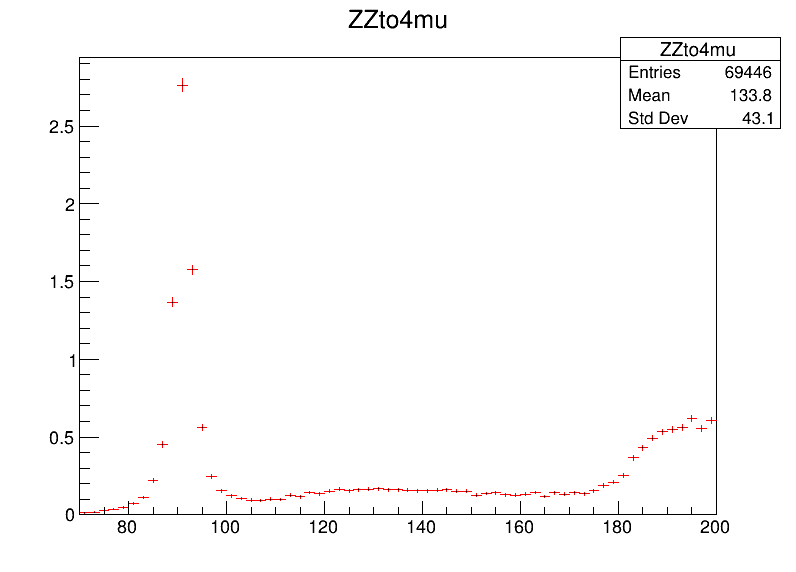

In [9]:
#selecting the 4u events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)
    if nGoodMuon != 4: continue 
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_ZZto4mu.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()

In [10]:
outf = r.TFile.Open('simu_histograms.root','RECREATE')
outf.cd()
h_ZZto4mu.Write()

1422

In [11]:
f = r.TFile("samples/ZZTo4e_skim.root")
f.ls()
t = f.Get("Events")
nEntries = t.GetEntries()
print(nEntries)

59030
TFile**		samples/ZZTo4e_skim.root	
 TFile*		samples/ZZTo4e_skim.root	
  KEY: TTree	Events;2	Events
  KEY: TTree	Events;1	Events


In [12]:
#Creating a histogram
h_ZZto4e = r.TH1F('ZZto4e','ZZto4e',65,70,200)
h_ZZto4e.SetFillColor(0)
h_ZZto4e.SetLineColor(r.kGreen)
h_ZZto4e.Draw()
c.Update()

In [13]:
xsec = 7.7241300E-02
nEvents = 1499093
lumi = (4.42+7.06)*1000
print(lumi)
weight = lumi * xsec / nEvents
print(weight)

11480.0
0.000591511083035


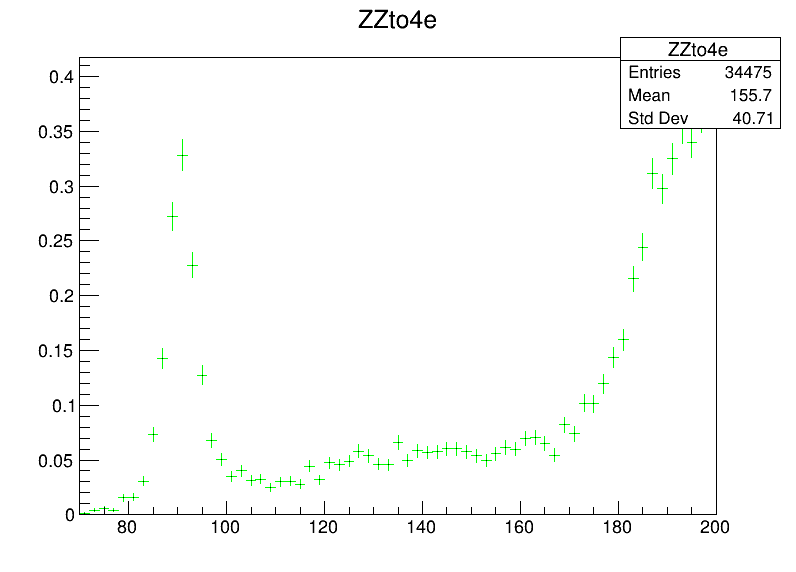

In [14]:
#selecting the 4e events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    nGoodElectron = 0
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if Erellso >= 0.3: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy / t.Electron_dxyErr[j]) ** 2 + (Edz / t.Electron_dzErr[j]) ** 2)
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)   
    if nGoodElectron != 4: continue
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_ZZto4e.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()

In [15]:
outf.cd()
h_ZZto4e.Write()

1371

In [16]:
f = r.TFile("samples/ZZTo2e2mu_skim.root")
f.ls()
t = f.Get("Events")
nEntries = t.GetEntries()
print(nEntries)

66888
TFile**		samples/ZZTo2e2mu_skim.root	
 TFile*		samples/ZZTo2e2mu_skim.root	
  KEY: TTree	Events;2	Events
  KEY: TTree	Events;1	Events


In [17]:
#Creating a histogram
h_ZZto2e2mu = r.TH1F('ZZto2e2mu','ZZto2e2mu',65,70,200)
h_ZZto2e2mu.SetFillColor(0)
h_ZZto2e2mu.SetLineColor(r.kMagenta)
h_ZZto2e2mu.Draw()
c.Update()

In [18]:
def compare(Zmass1,Zmass2):
    d1 = abs(90-Zmass1)
    d2 = abs(90-Zmass2)
    if d1>d2: return True
    return False

In [19]:
xsec = 1.7656500E-01
nEvents = 1497445
lumi = (4.42+7.06)*1000
print(lumi)
weight = lumi * xsec / nEvents
print(weight)

11480.0
0.00135361646004


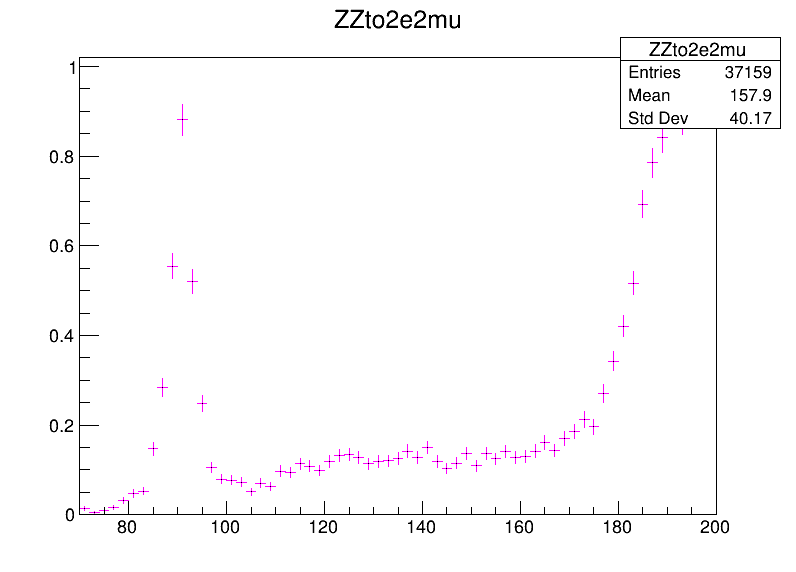

In [20]:
#selecting the 2e2u events
for i in range(0,nEntries):
    t.GetEntry(i)
    nGoodElectron = 0
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if Erellso >= 0.3: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy / t.Electron_dxyErr[j]) ** 2 + (Edz / t.Electron_dzErr[j]) ** 2)
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)       
    if nGoodElectron != 2: continue
    #2 electrons have the opposite charge    
    if totCharge != 0: continue    
    Zmass1 = invmass(Leptons)
    Lpt1 = max(Leptons[0]['pt'],Leptons[1]['pt'])
    Lpt2 = min(Leptons[0]['pt'],Leptons[1]['pt'])
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)    
    if nGoodElectron + nGoodMuon != 4: continue 
    #2 muons have the opposite charge     
    if totCharge != 0: continue  
    Zmass2 = invmass(Leptons[2:])  
    if (compare(Zmass1,Zmass2)):
        x = Zmass1
        Zmass1 = Zmass2
        Zmass2 = x
        Lpt1 = max(Leptons[2]['pt'],Leptons[3]['pt'])
        Lpt2 = min(Leptons[2]['pt'],Leptons[3]['pt'])
    if (Lpt1<=20)or(Lpt2<=10): continue    
    if (Zmass1<40)or(Zmass1>120): continue
    if (Zmass2<12)or(Zmass2>120): continue    
    h_ZZto2e2mu.Fill(invmass(Leptons),weight)
c.Update()
c.Draw()

In [21]:
outf.cd()
h_ZZto2e2mu.Write()

1379

In [22]:
f = r.TFile("samples/DYJetsToLL_skim.root")
f.ls()
t = f.Get("Events")
nEntries = t.GetEntries()
print(nEntries)

23705
TFile**		samples/DYJetsToLL_skim.root	
 TFile*		samples/DYJetsToLL_skim.root	
  KEY: TTree	Events;2	Events
  KEY: TTree	Events;1	Events


In [23]:
#Creating a histogram
h_DYJets = r.TH1F('DYJets','DYJets',65,70,200)
h_DYJets.SetFillColor(0)
h_DYJets.SetLineColor(r.kOrange)
h_DYJets.Draw()
c.Update()

In [24]:
xsec = 2.7903452E+03
nEvents = 30458871
lumi = (4.42+7.06)*1000
print(lumi)
weight = lumi * xsec / nEvents
print(weight)

11480.0
1.05168582565


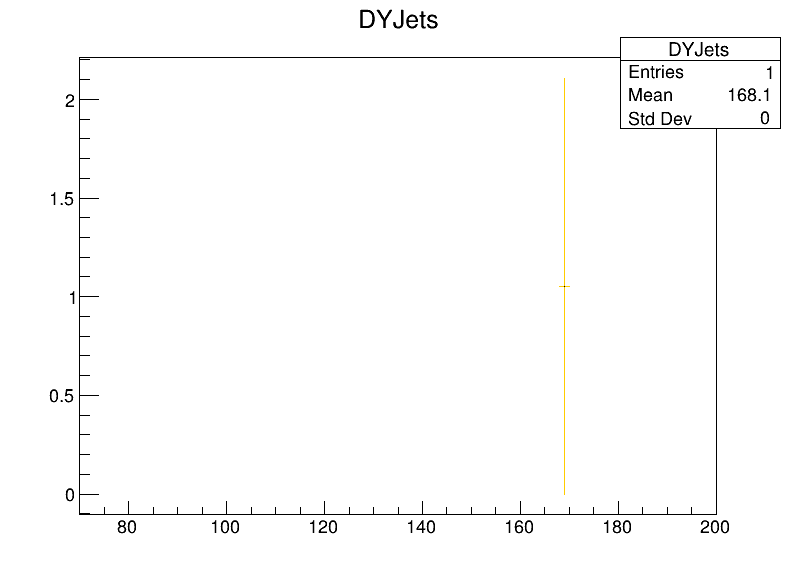

In [25]:
#selecting the 4u events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)
    if nGoodMuon != 4: continue 
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_DYJets.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()

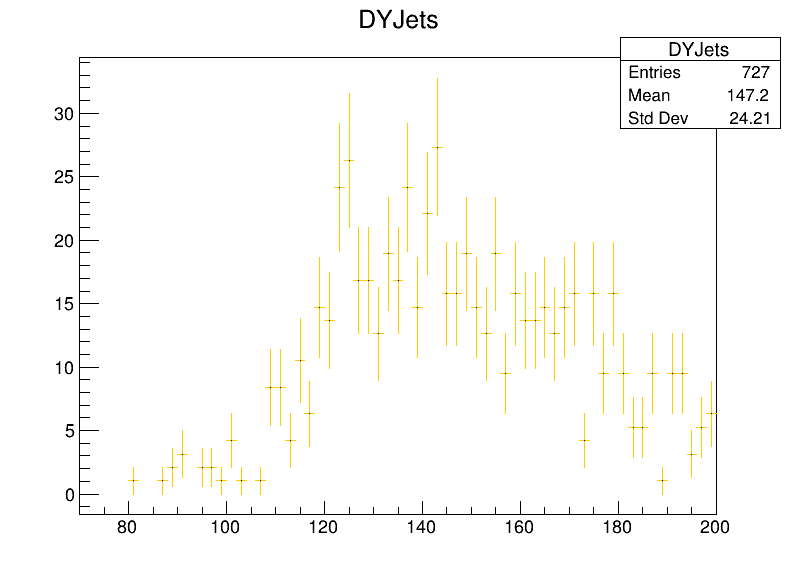

In [26]:
#selecting the 4e events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    nGoodElectron = 0
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if Erellso >= 0.3: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy / t.Electron_dxyErr[j]) ** 2 + (Edz / t.Electron_dzErr[j]) ** 2)
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)   
    if nGoodElectron != 4: continue
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_DYJets.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()

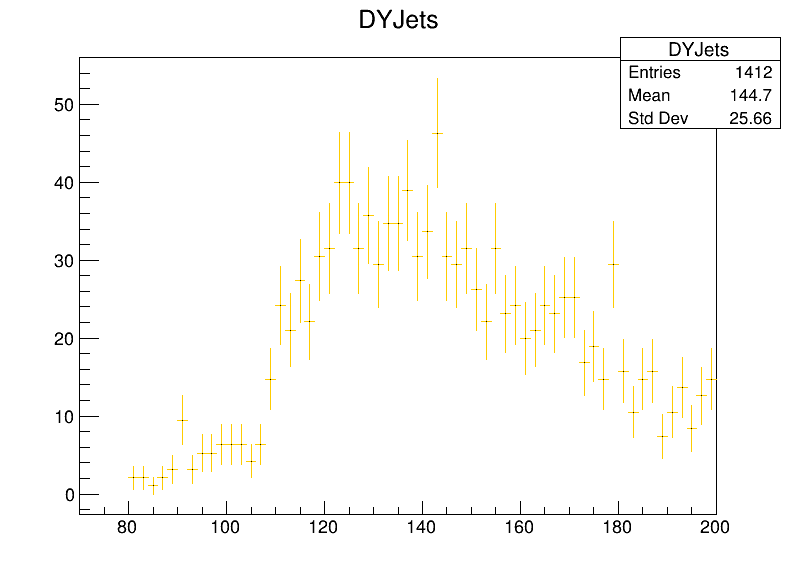

In [27]:
#selecting the 2e2u events
for i in range(0,nEntries):
    t.GetEntry(i)
    nGoodElectron = 0
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if Erellso >= 0.3: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy / t.Electron_dxyErr[j]) ** 2 + (Edz / t.Electron_dzErr[j]) ** 2)
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)       
    if nGoodElectron != 2: continue
    #2 electrons have the opposite charge    
    if totCharge != 0: continue    
    Zmass1 = invmass(Leptons)
    Lpt1 = max(Leptons[0]['pt'],Leptons[1]['pt'])
    Lpt2 = min(Leptons[0]['pt'],Leptons[1]['pt'])
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)    
    if nGoodElectron + nGoodMuon != 4: continue 
    #2 muons have the opposite charge     
    if totCharge != 0: continue  
    Zmass2 = invmass(Leptons[2:])  
    if (compare(Zmass1,Zmass2)):
        x = Zmass1
        Zmass1 = Zmass2
        Zmass2 = x
        Lpt1 = max(Leptons[2]['pt'],Leptons[3]['pt'])
        Lpt2 = min(Leptons[2]['pt'],Leptons[3]['pt'])
    if (Lpt1<=20)or(Lpt2<=10): continue    
    if (Zmass1<40)or(Zmass1>120): continue
    if (Zmass2<12)or(Zmass2>120): continue    
    h_DYJets.Fill(invmass(Leptons),weight)
c.Update()
c.Draw()

In [28]:
outf.cd()
h_DYJets.Write()

1106

In [29]:
f = r.TFile("samples/SMHiggsToZZTo4L_skim.root")
f.ls()
t = f.Get("Events")
nEntries = t.GetEntries()
print(nEntries)

20367
TFile**		samples/SMHiggsToZZTo4L_skim.root	
 TFile*		samples/SMHiggsToZZTo4L_skim.root	
  KEY: TTree	Events;2	Events
  KEY: TTree	Events;1	Events


In [35]:
#Creating a histogram
h_Higgs = r.TH1F('Higgs','Higgs',65,70,200)
h_Higgs.SetFillColor(0)
h_Higgs.SetLineColor(r.kBlack)
h_Higgs.Draw()
c.Update()

Warning in <TFile::Append>: Replacing existing TH1: Higgs (Potential memory leak).


In [31]:
xsec = 1.2932700E+01
nEvents = 299973
lumi = (4.42+7.06)*1000
print(lumi)
weight = lumi * xsec / nEvents
print(weight)

11480.0
0.494935864228


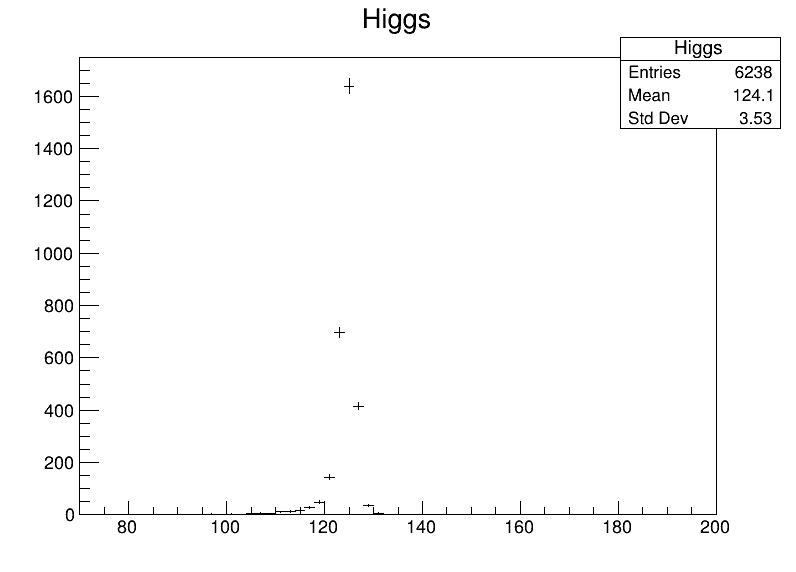

In [36]:
#selecting the 4u events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)
    if nGoodMuon != 4: continue 
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_Higgs.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()

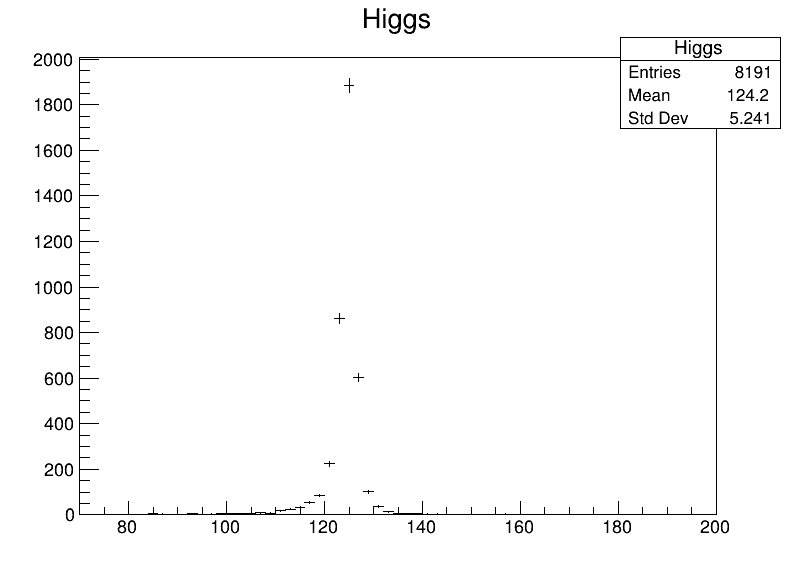

In [37]:
#selecting the 4e events
for i in range(0,nEntries):
    t.GetEntry(i)
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    nGoodElectron = 0
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if Erellso >= 0.3: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy / t.Electron_dxyErr[j]) ** 2 + (Edz / t.Electron_dzErr[j]) ** 2)
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)   
    if nGoodElectron != 4: continue
    if totCharge != 0: continue  
    Leptons = sorted(Leptons, key = lambda j:j['charge'], reverse =True)
    if (not check(Leptons)): continue
    h_Higgs.Fill(invmass(Leptons),weight)  
c.Update()
c.Draw()

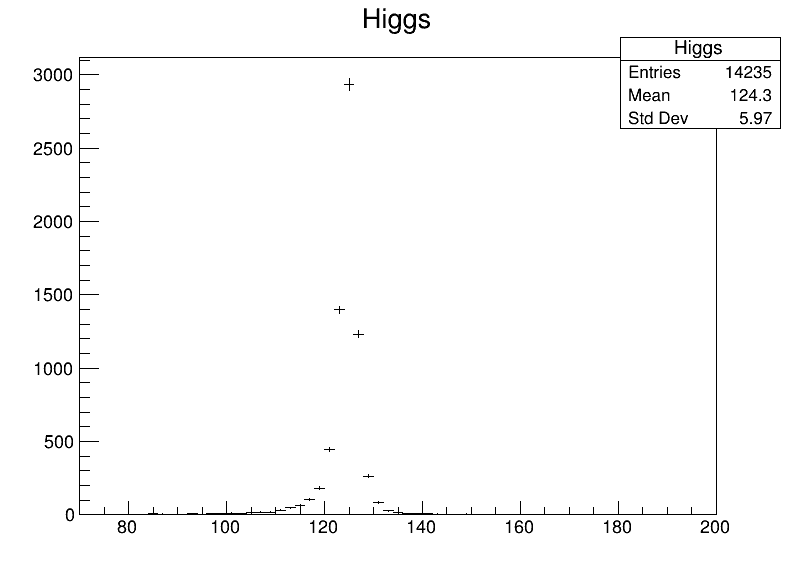

In [38]:
#selecting the 2e2u events
for i in range(0,nEntries):
    t.GetEntry(i)
    nGoodElectron = 0
    Leptons = list()
    totCharge = 0
    #filtering the good electrons
    for j in range(0,t.nElectron):
        #relative isolation
        Erellso = t.Electron_pfRelIso03_all[j]
        if Erellso >= 0.3: continue
        #transverse momentum 
        Ept = t.Electron_pt[j]
        if Ept <= 7: continue
        #pseudorapidity
        Eeta = t.Electron_eta[j]
        if abs(Eeta) >= 2.5: continue
        #Transverse impact parameter
        Edxy = t.Electron_dxy[j]
        if abs(Edxy) >= 0.5: continue
        #Longitudinal impact parameter
        Edz = t.Electron_dz[j]
        if abs(Edz) >= 1: continue
        #3D impact significance
        Esip = np.sqrt((Edxy / t.Electron_dxyErr[j]) ** 2 + (Edz / t.Electron_dzErr[j]) ** 2)
        if Esip >= 4: continue
        nGoodElectron += 1
        totCharge += t.Electron_charge[j]
        lepton = {
            'pt' : Ept,
            'phi' : t.Electron_phi[j],
            'eta' : Eeta,
            'mass' : t.Electron_mass[j],
            'charge' : t.Electron_charge[j],
        }
        Leptons.append(lepton)       
    if nGoodElectron != 2: continue
    #2 electrons have the opposite charge    
    if totCharge != 0: continue    
    Zmass1 = invmass(Leptons)
    Lpt1 = max(Leptons[0]['pt'],Leptons[1]['pt'])
    Lpt2 = min(Leptons[0]['pt'],Leptons[1]['pt'])
    #filtering the good muons    
    nGoodMuon = 0    
    for j in range(0,t.nMuon):
        #relative isolation
        Mrellso = t.Muon_pfRelIso04_all[j]
        if Mrellso >= 0.4: continue
        #transverse momentum 
        Mpt = t.Muon_pt[j]
        if Mpt <= 5: continue
        #pseudorapidity
        Meta = t.Muon_eta[j]
        if abs(Meta) >= 2.4: continue
        #Transverse impact parameter
        Mdxy = t.Muon_dxy[j]
        if abs(Mdxy) >= 0.5: continue
        #Longitudinal impact parameter
        Mdz = t.Muon_dz[j]
        if abs(Mdz) >= 1: continue
        #3D impact significance
        Msip = np.sqrt((Mdxy / t.Muon_dxyErr[j]) ** 2 + (Mdz / t.Muon_dzErr[j]) ** 2)
        if Msip >= 4: continue
        nGoodMuon += 1
        totCharge += t.Muon_charge[j]
        lepton = {
            'pt' : Mpt,
            'phi' : t.Muon_phi[j],
            'eta' : Meta,
            'mass' : t.Muon_mass[j],
            'charge' : t.Muon_charge[j],
        }
        Leptons.append(lepton)    
    if nGoodElectron + nGoodMuon != 4: continue 
    #2 muons have the opposite charge     
    if totCharge != 0: continue  
    Zmass2 = invmass(Leptons[2:])  
    if (compare(Zmass1,Zmass2)):
        x = Zmass1
        Zmass1 = Zmass2
        Zmass2 = x
        Lpt1 = max(Leptons[2]['pt'],Leptons[3]['pt'])
        Lpt2 = min(Leptons[2]['pt'],Leptons[3]['pt'])
    if (Lpt1<=20)or(Lpt2<=10): continue    
    if (Zmass1<40)or(Zmass1>120): continue
    if (Zmass2<12)or(Zmass2>120): continue    
    h_Higgs.Fill(invmass(Leptons),weight)
c.Update()
c.Draw()